# Note
Pay attention that The size of the images in this dataset is different. You can resize the image to the desired size after pre-processing and removing the extra margins. This work will improve the accuracy of the model pre-processing code

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is enabled!")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not enabled.")

GPU is not enabled.


In [2]:
# Load datasets
from torchvision.datasets import ImageFolder 
from torchvision import transforms 

train_transforms = transforms.Compose([ 
transforms.ToTensor(), 
transforms.Resize((256, 256)),     # (512, 512)
])

train_data = ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Training", transform=train_transforms)
test_data = ImageFolder("/kaggle/input/brain-tumor-mri-dataset/Testing", transform=train_transforms)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/brain-tumor-mri-dataset/Training
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )
Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /kaggle/input/brain-tumor-mri-dataset/Testing
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )


In [3]:
print(type(train_data))
print(train_data.class_to_idx)
print(f"Number of images: {len(train_data)}")
print(f"Number of classes: {len(train_data.classes)}")

num_classes = len(train_data.classes)

<class 'torchvision.datasets.folder.ImageFolder'>
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Number of images: 5712
Number of classes: 4


Image Shape: torch.Size([256, 256, 3])
Image Label: 2


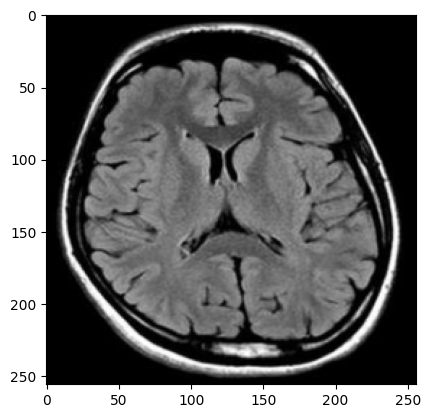

torch.Size([256, 256, 3])


In [4]:
# Train DataLoader
dataloader_train = DataLoader(train_data, shuffle =True, batch_size = 60)

images, labels = next(iter(dataloader_train))

image = images[0]
image = image.squeeze().permute(1, 2, 0)    # The images have 3 channels
label = labels[0]
# OR DIRECTLY WITHOUT USING DATA LOADER: 
# image, label = train_data[0]

print(f"Image Shape: {image.shape}")    # 1: batch size, 1: one color channel, 28 * 28: H * W
print(f"Image Label: {label}")

image = image.squeeze()    # OR: image = image.squeeze(0).permute(1, 2, 0)
plt.imshow(image)
plt.show()
print(image.shape)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNWithTransformer(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNWithTransformer, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Transformer Layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8), num_layers=6
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)  # Adjust size to match embedding dimension
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Pass through convolution layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Get the output dimensions after the convolutional layers
        batch_size, channels, height, width = x.size()  # (batch_size, channels, height, width)

        # Reshape the output for the transformer
        # Flatten spatial dimensions (height * width) and use channels as embedding_dim
        x = x.view(batch_size, channels, height * width).permute(2, 0, 1)  # Shape: (seq_len, batch_size, channels)
        
        # Pass through the transformer
        x = self.transformer(x)
        
        # Global average pooling after transformer (averaging the sequence dimension)
        x = x.mean(dim=0)  # Shape: (batch_size, channels)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # Pass through the first fully connected layer
        x = self.dropout(x)      # Apply dropout
        x = self.fc2(x)          # Output layer
        
        return x


# TRAINING LOOP

In [ ]:
from tqdm import tqdm
cnn = CNNWithTransformer(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

nbr_epochs = 3  # 2
for i in tqdm(range(nbr_epochs)):
    for images, labels in dataloader_train:  # dataloader's batch size=64 ==> images & labels are both of size 64
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████| 3/3 [07:49<00:00, 156.61s/it]


In [9]:
print(outputs.shape)

torch.Size([12, 4])


# EVALUATION LOOP (TEST)

In [10]:
# Test DataLoader
dataloader_test = DataLoader(test_data, shuffle = False, batch_size = 60)

# Metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)

transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Evaluation Loop
cnn.eval()
predictions = []
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = cnn(images) # cnn(images.reshape(-1, 1, 28, 28)), in this case: predicted_classes = torch.argmax(outputs, dim=-1) (change dim to -1 in the next line)
        _, predicted_classes = torch.max(outputs, dim=1)   # max_values, max_indices(predicted_classes (idx))
        accuracy_metric(predicted_classes, labels)
        precision_metric(predicted_classes, labels)
        recall_metric(predicted_classes, labels)
        
        predictions.extend(predicted_classes.tolist())   # required a predictions list

In [11]:
print(outputs.shape)
print(predicted_classes.shape)
print(predicted_classes)

print(len(predictions))

torch.Size([51, 4])
torch.Size([51])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3])
1311


In [14]:
# Compute metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()

# Print the results in a more readable format
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8009153604507446
Precision: [0.954285740852356, 0.6631205677986145, 0.8112449645996094, 0.8202247023582458]
Recall: [0.5566666722297668, 0.6111111044883728, 0.9975308775901794, 0.9733333587646484]


In [15]:
torch.save(cnn.state_dict(), 'trained_model.pth')

In [17]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.4 MB/s eta 0:00:00:00:0100:01


In [60]:
%%writefile my_app.py

import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNWithTransformer(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNWithTransformer, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Transformer Layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8), num_layers=6
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)  # Adjust size to match embedding dimension
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Pass through convolution layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Get the output dimensions after the convolutional layers
        batch_size, channels, height, width = x.size()  # (batch_size, channels, height, width)

        # Reshape the output for the transformer
        # Flatten spatial dimensions (height * width) and use channels as embedding_dim
        x = x.view(batch_size, channels, height * width).permute(2, 0, 1)  # Shape: (seq_len, batch_size, channels)
        
        # Pass through the transformer
        x = self.transformer(x)
        
        # Global average pooling after transformer (averaging the sequence dimension)
        x = x.mean(dim=0)  # Shape: (batch_size, channels)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # Pass through the first fully connected layer
        x = self.dropout(x)      # Apply dropout
        x = self.fc2(x)          # Output layer
        
        return x


# Load the saved model weights
def load_model():
    model = MultiClassCNN(num_classes=4)  # 4 classes: glioma, meningioma, notumor, pituitary
    model.load_state_dict(torch.load('trained_model.pth'))  # Load the trained model weights
    model.eval()  # Set the model to evaluation mode
    return model

# Define class names
class_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Preprocess the uploaded image
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match input size expected by model
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Streamlit interface
st.write("Upload an image of a brain scan to predict the tumor type.")

# Image uploader widget
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    # Open and display the image
    image = Image.open(uploaded_file)
    
    st.image(image, caption="Uploaded Image", use_container_width=True)
    
    # Load the model and preprocess the image
    model = load_model()  
    input_tensor = preprocess_image(image)
    
    # Run the model inference
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
    
    # Display the prediction
    predicted_label = class_names[predicted_class.item()]
    st.write(f"Predicted Class: {predicted_label}")


Overwriting my_app.py


In [30]:
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken token

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [61]:
get_ipython().system_raw('ngrok http 8501 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://cc5d-35-204-238-200.ngrok-free.app


In [62]:
!streamlit run ./my_app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.204.238.200:8501

/kaggle/working/my_app.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 